# Comparaison des prédictions des différentes lignées cellulaires et du modèle estimé par apprentissage de transfert sur certaines séquences de test

In [1]:
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import h5py
import cooler

In [3]:
from basenji import dataset

In [4]:
import matplotlib.pyplot as plt

In [5]:
predpath = "/home/bureau/projects/def-bureau/bureau/ran-donnees/PredictNeuronHi-C/akita_pred_test/"
predfile = predpath + "preds.h5"

In [6]:
pred = h5py.File(predfile, 'r')
pred

<HDF5 file "preds.h5" (mode r)>

In [7]:
pred.keys()

<KeysViewHDF5 ['preds']>

In [8]:
pred['preds'].shape

(6668, 99681, 5)

In [9]:
#targetfile = "/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1s/seqs_cov/0.h5"
data_dir = "/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1s/"
test_data = dataset.SeqDataset(data_dir, 'test', batch_size=8)

In [10]:
# Les données de tests sont les 6667 (pred['preds'].shape[0]) dernières
#test_targets = targets['targets'][targets['targets'].shape[0]-pred['preds'].shape[0]:,]
test_targets = test_data.numpy(return_inputs=False, return_outputs=True)

In [11]:
test_targets.shape

(6668, 99681, 1)

In [12]:
predhpath = "/home/bureau/projects/def-bureau/bureau/ran-donnees/PredictNeuronHi-C/akita_pred_transfer_test/"
predhfile = predhpath + "preds.h5"
predf = h5py.File(predhfile, 'r')
predf

<HDF5 file "preds.h5" (mode r)>

In [13]:
predf.keys()

<KeysViewHDF5 ['preds']>

In [14]:
predf['preds'].shape

(6668, 99681, 1)

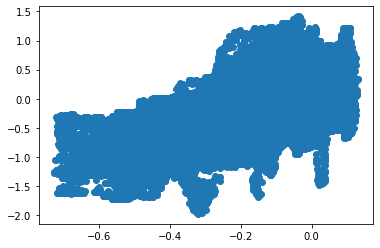

In [16]:
plt.scatter(predf['preds'][0,:,0], test_targets[0,:,0])
plt.show()

In [17]:
hic_targets = pd.read_csv('/home/bureau/projects/def-bureau/basenji/manuscripts/akita/data/targets.txt',sep='\t')
hic_targets

,index,identifier,file,clip,description
0,0,HFF,../../data/coolers/Krietenstein2019/HFF_hg38_4...,2,HFF
1,1,H1hESC,../../data/coolers/Krietenstein2019/H1hESC_hg3...,2,H1hESC
2,2,GM12878,../../data/coolers/Rao2014/GM12878_inSitu_MboI...,2,GM12878
3,3,IMR90,../../data/coolers/Rao2014/IMR90_inSitu_MboI_a...,2,IMR90
4,4,HCT116,../../data/coolers/Rao2017/Unsynchronized_all....,2,HCT116


## Décalage entre les cibles / Lag between targets

In [18]:
params_file = "/home/bureau/projects/def-bureau/basenji/manuscripts/akita/params.json"
with open(params_file) as params_open:
    params = json.load(params_open)
    params_model = params['model']
    params_train = params['train']

seq_length = params_model['seq_length']
target_length = params_model['target_length']
target_crop = params_model['target_crop']
hic_diags = 2
target_length_cropped = target_length - 2*target_crop
# Longueur d'une cible dans la séquence / length of a target in the sequence
n = target_length_cropped - hic_diags
# Longueur d'un vecteur cible extrait du triangle supérieur de la matrice de contacts 3D / 
# length of a target vector extracted from the upper triangle of the 3D contact matrix
tlen = n * (n+1) // 2
tlen

99681

In [30]:
# Nombre de bacs de séquences par lequel on décale / striding by this number of sequence bins
k = 16
# Décalage dans le vecteur cible / Lag in target vector corresponding to striding in sequence bins
decal = []
for h in range(1,10):
    decal.append(int(k*(n-h/2*(h*k-1)/2)))
decal

[7076, 6888, 6572, 6128, 5556, 4856, 4028, 3072, 1988]

### Examen des mêmes points de contact dans plusieurs cible / Inspection of same contact points in multiple targets

In [31]:
# Les valeurs sont très différentes / the values differ greatly
display([test_targets[1,0],test_targets[0,decal[0]]])
display([test_targets[2,0],test_targets[1,decal[0]],test_targets[0,decal[0]+decal[1]]])
display([test_targets[3,0],test_targets[2,decal[0]],test_targets[1,decal[0]+decal[1]],test_targets[0,decal[0]+decal[1]+decal[2]]])

[0.02068, -0.667]

[-0.002596, -1.335, -0.6416]

[-0.03436, -0.8813, 0.01651, -0.1754]

In [32]:
# 10e bac / 10th bin
display([test_targets[1,10],test_targets[0,10+decal[0]]])
display([test_targets[2,10],test_targets[1,10+decal[0]],test_targets[0,10+decal[0]+decal[1]]])
display([test_targets[3,10],test_targets[2,10+decal[0]],test_targets[1,10+decal[0]+decal[1]],test_targets[0,10+decal[0]+decal[1]+decal[2]]])

[0.2172, -0.3945]

[-0.151, -0.5703, -0.7236]

[0.01546, -0.0787, -0.1566, -0.2062]

## Trouver une valeur égale dans une autre séquence

In [20]:
tmp = list(abs(test_targets[0,:,0]-test_targets[1,0,0])<0.0001)
tmp.index(True)

27884

In [21]:
[test_targets[1,0,0],test_targets[0,tmp.index(True),0]]

[0.02068, 0.02061]

In [22]:
tmp = list(abs(test_targets[10,:,0]-test_targets[13,4,0])<0.0001)
tmp.index(True)

4040

In [23]:
index_vec = []
for j in range(14):
    tmp = list(abs(test_targets[j,:,0]-test_targets[14,2,0])<0.0001)
    index_vec.append(tmp.index(True))
index_vec

[17437,
 37678,
 11263,
 30371,
 1258,
 1210,
 1151,
 14922,
 15438,
 18811,
 4099,
 23081,
 15757,
 3525]

In [37]:
len(index_vec)

14

In [25]:
display(test_targets[14,2,0])
for j in range(len(index_vec)):
    display(test_targets[j,index_vec[j],0])

-0.0855

-0.0856

-0.08545

-0.08545

-0.0856

-0.0856

-0.0855

-0.0856

-0.08545

-0.08545

-0.0855

-0.08545

-0.08545

-0.0855

-0.08545

In [26]:
# Extraction des prédictions originales d'Akita
pred_orig = np.zeros((len(index_vec)+1,pred['preds'].shape[2]))
for j in range(len(index_vec)):
    pred_orig[j] = pred['preds'][j,index_vec[j],]
pred_orig[len(index_vec)] = pred['preds'][len(index_vec),2,]
pred_orig

array([[-8.44726562e-02, -1.10229492e-01, -8.31298828e-02,
        -6.19812012e-02, -4.58068848e-02],
       [ 5.99975586e-02,  5.30090332e-02, -6.11305237e-04,
         5.93566895e-02,  3.96728516e-02],
       [-6.31347656e-01, -4.20654297e-01, -5.20019531e-01,
        -6.78710938e-01, -4.26757812e-01],
       [-1.04101562e+00, -8.14453125e-01, -5.95214844e-01,
        -9.50683594e-01, -5.22460938e-01],
       [ 2.07519531e-01,  1.12487793e-01,  8.14819336e-02,
         1.87622070e-01,  1.23107910e-01],
       [-1.49047852e-01, -4.34570312e-02, -1.18835449e-01,
        -1.55883789e-01, -9.50317383e-02],
       [-3.55224609e-01, -2.88818359e-01, -2.95166016e-01,
        -3.71826172e-01, -2.34863281e-01],
       [ 2.21923828e-01,  1.69433594e-01,  9.82055664e-02,
         1.61254883e-01,  1.10351562e-01],
       [-6.94335938e-01, -5.90820312e-01, -4.37255859e-01,
        -7.15332031e-01, -3.72802734e-01],
       [-3.23486328e-02, -5.35888672e-02, -7.41577148e-02,
        -3.52478027e-02

In [27]:
pred_transfer = []
for j in range(len(index_vec)):
    pred_transfer.append(predf['preds'][j,index_vec[j],0])
pred_transfer.append(predf['preds'][len(index_vec),2,0])
pred_transfer

[-0.1475,
 0.0899,
 -0.4165,
 -0.4614,
 0.1295,
 0.04745,
 -0.08496,
 0.1088,
 -0.4148,
 -0.1516,
 0.01552,
 -0.0176,
 0.206,
 -0.2109,
 -0.12366]

In [41]:
pred_dat = pd.DataFrame(pred_orig,columns=hic_targets['identifier'])
pred_dat["Neuron"] = pred_transfer
pred_dat

identifier,HFF,H1hESC,GM12878,IMR90,HCT116,Neuron
0,-0.084473,-0.110229,-0.083130,-0.061981,-0.045807,-0.147461
1,0.059998,0.053009,-0.000611,0.059357,0.039673,0.089905
2,-0.631348,-0.420654,-0.520020,-0.678711,-0.426758,-0.416504
3,-1.041016,-0.814453,-0.595215,-0.950684,-0.522461,-0.461426
4,0.207520,0.112488,0.081482,0.187622,0.123108,0.129517
5,-0.149048,-0.043457,-0.118835,-0.155884,-0.095032,0.047455
6,-0.355225,-0.288818,-0.295166,-0.371826,-0.234863,-0.084961
7,0.221924,0.169434,0.098206,0.161255,0.110352,0.108826
8,-0.694336,-0.590820,-0.437256,-0.715332,-0.372803,-0.414795
9,-0.032349,-0.053589,-0.074158,-0.035248,-0.008125,-0.151611


In [42]:
# Biais
bias = pred_dat.mean() - test_targets[len(index_vec),2]
bias

identifier
HFF       -0.071924
H1hESC    -0.032085
GM12878   -0.055608
IMR90     -0.081690
HCT116    -0.010185
Neuron    -0.009934
dtype: float64

In [43]:
# Biais estimé avec la médiane
bias_med = pred_dat.median() - test_targets[len(index_vec),2]
bias_med

identifier
HFF        0.053162
H1hESC     0.042053
GM12878    0.002380
IMR90      0.050262
HCT116     0.046875
Neuron     0.000549
dtype: float64

In [44]:
var = pred_dat.var()
var

identifier
HFF        0.135184
H1hESC     0.088140
GM12878    0.048350
IMR90      0.122243
HCT116     0.040716
Neuron     0.043964
dtype: float64

In [45]:
# MSE
bias*bias + var

identifier
HFF        0.140357
H1hESC     0.089170
GM12878    0.051442
IMR90      0.128917
HCT116     0.040820
Neuron     0.044063
dtype: float64

In [46]:
# Corrélation
pred_dat.corr()

identifier,HFF,H1hESC,GM12878,IMR90,HCT116,Neuron
identifier,,,,,,
HFF,1.000000,0.980279,0.982197,0.994760,0.988639,0.881402
H1hESC,0.980279,1.000000,0.964184,0.970200,0.965965,0.914968
GM12878,0.982197,0.964184,1.000000,0.989699,0.996861,0.909415
IMR90,0.994760,0.970200,0.989699,1.000000,0.993188,0.883984
HCT116,0.988639,0.965965,0.996861,0.993188,1.000000,0.893991
Neuron,0.881402,0.914968,0.909415,0.883984,0.893991,1.000000


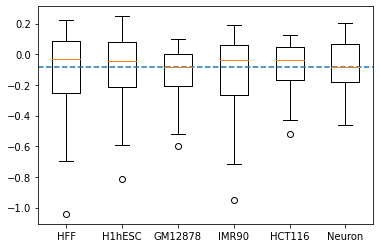

In [47]:
plt.boxplot(pred_dat,labels=pred_dat.columns)
plt.axhline(y=test_targets[len(index_vec),2], ls='--')
plt.show()

In [48]:
# Test de Wilcoxon
from scipy import stats
stats.wilcoxon(pred_dat["Neuron"],pred_dat["HCT116"])

WilcoxonResult(statistic=57.0, pvalue=0.8647045760375567)

In [49]:
stats.wilcoxon(pred_dat["Neuron"],pred_dat["GM12878"])

WilcoxonResult(statistic=30.0, pvalue=0.08840247992639415)

## Comparaison visuelle des prédictions aux cibles/ Visual comparison of predictions to targets

In [28]:
sequences = pd.read_csv('/home/bureau/projects/def-bureau/bureau/distiller/iPSC/data/1s/sequences.bed',sep='\t',  names=['chr','start','stop','type'])
sequences_test = sequences.iloc[  sequences['type'].values=='test']
sequences_test.reset_index(inplace=True, drop=True)

In [29]:
fig2_examples = [   'chr12:106084352-107132928',
                    'chr11:90097664-91146240',
                    'chr15:42508288-43556864' ]
fig2_inds = []
for seq in fig2_examples:
    print(seq)
    chrm,start,stop = seq.split(':')[0], seq.split(':')[1].split('-')[0], seq.split(':')[1].split('-')[1]
    test_ind = np.where( (sequences_test['chr'].values== chrm) *
                         (sequences_test['start'].values== int(start))*
                         (sequences_test['stop'].values==  int(stop ))  )[0][0]
    fig2_inds.append(test_ind)
fig2_inds

chr12:106084352-107132928
chr11:90097664-91146240
chr15:42508288-43556864


[4972, 6192, 2483]

In [30]:
### for converting from flattened upper-triangluar vector to symmetric matrix  ###
from cooltools.lib.numutils import set_diag

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

 
chr12:106084352-107132928


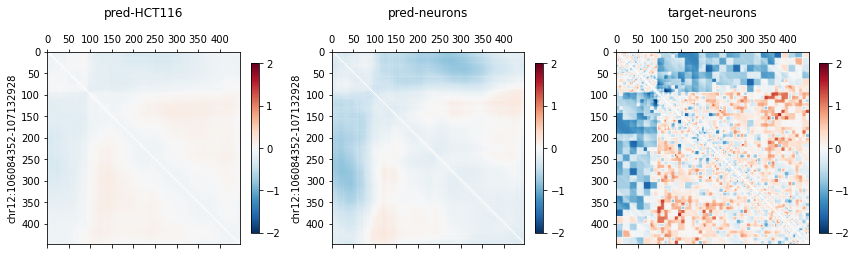

 
chr11:90097664-91146240


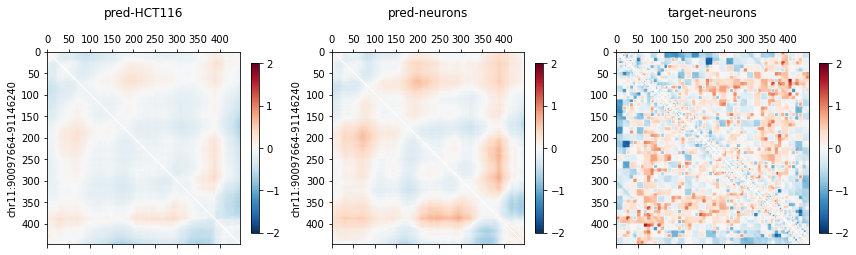

 
chr15:42508288-43556864


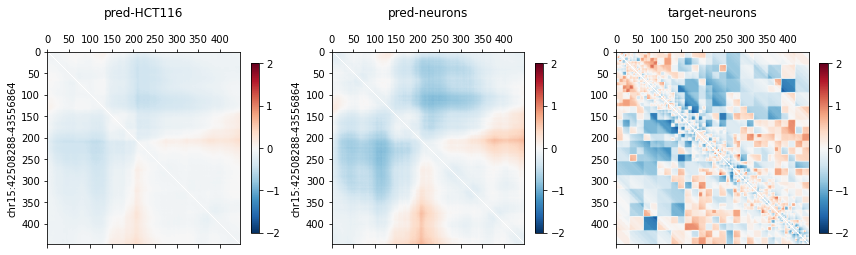

In [42]:
### make predictions and plot the three examples above ###
hic_num_to_name_dict = dict(zip(hic_targets['index'].values, hic_targets['identifier'].values) )
target_index = 4 # HCT116 

for test_index in fig2_inds:
    chrm, seq_start, seq_end = sequences_test.iloc[test_index][0:3]
    myseq_str = chrm+':'+str(seq_start)+'-'+str(seq_end)
    print(' ')
    print(myseq_str)
    
    test_target = test_targets[test_index:test_index+1,:,0]
    test_pred = pred['preds'][test_index:test_index+1,:,:]
    test_predf = predf['preds'][test_index:test_index+1,:,0]

    plt.figure(figsize=(12,4))
    vmin=-2; vmax=2

    # plot pred HCT116
    plt.subplot(131) 
    mat = from_upper_triu(test_pred[:,:,target_index], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-'+str(hic_num_to_name_dict[target_index]),y=1.15 )
    plt.ylabel(myseq_str)
    
    # plot pred neurons
    plt.subplot(132) 
    mat = from_upper_triu(test_predf[:,:], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('pred-neurons',y=1.15 )
    plt.ylabel(myseq_str)
    

    # plot target 
    plt.subplot(133) 
    mat = from_upper_triu(test_target[:,:], target_length_cropped, hic_diags)
    im = plt.matshow(mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title( 'target-neurons',y=1.15)

    plt.tight_layout()
    plt.show()

### Calcul de l'erreur quadratique moyenne / computation of mean squared error

In [43]:
from sklearn.metrics import explained_variance_score

In [44]:
r2_transfer_seq = np.zeros(3)
for j in range(3):
    r2_transfer_seq[j] = explained_variance_score(test_targets[fig2_inds[j],],pred['preds'][fig2_inds[j],:,0])

In [45]:
display(r2_transfer_seq)

array([ 0.39160156, -0.03125   ,  0.26708984])